In [1]:
# run this cell to setup matplotlib, and also import the very important take_picture function from camera!
%matplotlib notebook
import matplotlib.pyplot as plt
from camera import take_picture
import numpy as np
from PIL import Image
from facenet_models import FacenetModel

model = FacenetModel()

In [5]:
def cos_dist(di, dj):
    dot_prod = np.vdot(di, dj)
    denom = sum(i**2 for i in di.T)**0.5 * sum(j**2 for j in dj.T)**0.5
    cosine_dist = 1 - dot_prod/denom
    return float(cosine_dist)

In [6]:
def identify(test, names, means, cutoff=1):
    """Takes in the test descriptor, database, and an optional cuttoff value, defaulted to 1
    Outputs a 1D array with the values [min_distance,place_found]. place_found = None if there is no values
    that give a cos-dist of less than the cutoff"""
    min_cos_dist = 2
    min_name = ""
    for i in range(0, len(names)):
        if cos_dist(test,means[i]) < min_cos_dist:
            min_name = names[i]
            min_cos_dist = cos_dist(test,means[i])
    print(min_cos_dist, "Min Cosine Distance")
    if min_cos_dist > 0.65: # 0.65 is the cutoff
        min_name = "No Match"
    return min_name

# Database Code:

In [31]:
"""
Provide utilities for managing the face-recognition database. Lower-cased full names ('first last')
are used as keys into the dictionary-database of profiles. Each profile-instances stores all of
the face-descriptors added for that person as well as the mean face-descriptor.
The database is saved in this directory as 'face_db.pkl'
"""


import os as _os
import pickle as _pickle
from pathlib import Path as _Path
from typing import Dict, Iterable, List, Optional, Tuple, TypeVar, Union

import numpy as np
import numpy as _np
import skimage.io as _io
from facenet_models import FacenetModel

_T = TypeVar("_T")

__all__ = [
    "add_images",
    "add_descriptors",
    "delete_profile",
    "descriptors_to_best_matches",
    "get_profile",
    "image_to_best_matches",
    "load_face_db",
    "save",
    "switch_db",
]

_default_path = _Path(_os.path.dirname(_os.path.abspath(r"C:\Users\nrabi\Documents\Vision_Project\Facial_Recog\facial-recognition"))) / "face_db.pkl"
_path = _default_path # MODIFY FILE PATH ABOVE FOR YOUR COMPUTER


class _Profile:
    """ Saves profile information in the face-recognition database."""

    def __init__(self, name: str):
        """
        Parameters
        ----------
        name : str
            '<first-name> <last-name>' used to identify the database profile.
        """
        self.name = name
        try:
            self.first, self.last = name.split()
        except TypeError:
            raise TypeError(
                "A face-database profile name must have a first and last name: 'John Smith' "
            )
        self._descriptors: Optional[np.ndarray] = None
        self._mean: Optional[np.ndarray] = None

    def add_descriptors(self, descriptors: np.ndarray):
        """Add descriptors to profile.
        Parameters
        ----------
        descriptors : numpy.ndarray
            One, shape=(D,), or more, shape=(N, D), descriptor arrays.
        """
        if self._descriptors is None:
            if descriptors.ndim == 1:
                descriptors = descriptors[_np.newaxis, :]
            self._descriptors = descriptors
        else:
            self._descriptors = _np.vstack([self._descriptors, descriptors])
        self._mean = self._descriptors.mean(axis=0)

    @property
    def num_entries(self) -> int:
        """Returns the number of descriptors stored for this profile.
        Returns
        -------
        int
        """
        return 0 if self._descriptors is None else len(self._descriptors)

    @property
    def mean(self) -> np.ndarray:
        """The average descriptor for this profile.
        Returns
        -------
        numpy.ndarray, shape=(D,)
        """
        return self._mean


_face_db: Optional[Dict[str, _Profile]] = None


def _load(force: bool = False):
    """Load the database from face_rec/face_db/face_db.pkl if it isn't
    already loaded.
    Call this if you want to load the database up front. Otherwise,
    the other database methods will automatically load it.
    """
    global _face_db
    if _face_db is not None and not force:
        return None

    if not _path.is_file():
        print(
            f"No face-database found. Creating empty database...\n\tSaving it will save to {_path.absolute()}"
        )
        _face_db = dict()
    else:
        with _path.open(mode="rb") as f:
            _face_db = _pickle.load(f)
        print(f"face-database loaded from: {_path.absolute()}")


def load_face_db(func: Optional[_T] = None) -> _T:
    """This function can be invoked directly to lazy-load the face-recognition database, or it can
    be used as a decorator: the database is lazy-loaded prior to invoking the decorated function.
    See face_rec.face_db._load for more information.
    Parameters
    ----------
    func : Optional[Callable]
    Returns
    -------
    Union[None, Callable]
    """
    if func is None:
        _load()
        return None

    from functools import wraps

    @wraps(func)
    def wrapper(*args, **kwargs):
        _load()
        return func(*args, **kwargs)

    return wrapper


def save():
    """ Save the database."""
    if _face_db is None:
        print("No changes to face-database to save")
        return None

    with _path.open(mode="wb") as f:
        _pickle.dump(_face_db, f)

    print(f"Face database saved to: {_path.absolute()}")


def switch_db(path: Optional[Union[str, _Path]] = None):
    """Switch the face database being used by specifying its load/save path. Calling this
    function with no argument will revert to the default database.
    Providing a name with no directories will assume face_rec/face_db as the directory,
    otherwise the provided path is used. All databases will be saved as .pkl files.
    Parameters
    ----------
    path : PathLike
    """
    from pathlib import Path

    global _face_db
    _backup_db = _face_db

    global _path
    _backup_path = _path

    try:
        if path is not None:
            path = Path(path)
            parent = path.parent if str(path.parent) != "." else _default_path.parent
            _path = parent / (path.stem + ".pkl")
        else:
            _path = _default_path
        _face_db = None
        load_face_db()
    except Exception as e:
        print(f"The following error occurred: {e}")
        print(f"\nReverting to your prior database state at: {_path.absolute()}")
        _face_db = _backup_db
        _path = _backup_path


@load_face_db
def add_images(
    name: str,
    items: Union[str, _Path, np.ndarray, Iterable[Union[str, _Path, np.ndarray]]],
):
    """Extract face-descriptors from the provided images, and add them to the
    face-recognition database.
    A new profile will be created if `name.lower()` is not in the database.
    Parameters
    ----------
    name : str
        '<first-name> <last-name>' used to identify the database profile.
    items : Union[PathLike, numpy.ndarray, Sequence[Union[PathLike, numpy.ndarray]]]
        One or more paths to images, or RGB-valued numpy arrays, from which the descriptors
        are extracted. Each image must contain exactly one face.
    """

    try:
        _, _ = name.split()
    except TypeError:
        raise TypeError(
            "A face-database profile name must have a first and last name: 'John Smith' "
        )

    if isinstance(items, (str, _Path)) or (
        isinstance(items, _np.ndarray) and items.ndim == 3
    ):
        items = [items]

    def to_3_channel(x):
        return x[..., :-1] if x.shape[-1] == 4 else x  # png -> RGB

    arrays = (
        to_3_channel(_io.imread(x)) if isinstance(x, (str, _Path)) else x for x in items
    )

    descriptors = []
    model = FacenetModel()

    for n, array in enumerate(arrays):
        boxes, _, _ = model.detect(array)

        # each picture should contain one face
        if boxes is None:
            continue
        elif len(boxes) != 1:
            print(f"Warning: item {n} contains a picture with {len(boxes)} faces")
            print("This item was skipped.. each item should contain exactly 1 face")
            continue

        descriptors.append(model.compute_descriptors(array, boxes))

    if descriptors:
        name = name.lower()
        profile = _face_db.setdefault(name, _Profile(name))
        profile.add_descriptors(_np.vstack(descriptors))
        print(
            f"{name} had {len(descriptors)} descriptors added to their profile; {profile.num_entries} in total"
        )


@load_face_db
def add_descriptors(names: Iterable[str], descriptors: Iterable[np.ndarray]):
    """Add descriptors for multiple database profiles.
    Parameters
    ----------
    names : Iterable[str]
        N names.
    descriptors : Sequence[numpy.ndarray]
        A sequence of N descriptors/descriptor-blocks. That is,
        each element of the sequence can be a (512,) array or
        a (M, 512) array, corresponding to M descriptors for that
        profile.
    """
    for name, descriptor in zip(names, descriptors):
        if name is None:
            continue
        name = name.lower()
        profile = _face_db.setdefault(name, _Profile(name))
        profile.add_descriptors(descriptor)


@load_face_db
def list_entries() -> List[str]:
    """Returns a list of alphabetized profile-names in the database.
    Returns
    -------
    List[str]
    """
    return sorted(_face_db.keys())


@load_face_db
def get_profile(key: str):
    """Returns the profile-instance for the specified profile-name from the database.
    Parameters
    ----------
    key : str
        '<first-name> <last-name>' used to identify the database entry.
    Returns
    -------
    face_rec.face_db._Profile
    """
    return _face_db[key.lower()]


@load_face_db
def delete_profile(key: str):
    """Removes the specified profile from the database.
    Parameters
    ----------
    key : str
        '<first-name> <last-name>' used to identify the database entry.
    """
    _face_db.pop(key)


In [8]:
list_entries()
keys, means = zip(*((name, profile.mean) for name, profile in _face_db.items()))

face-database loaded from: C:\Users\nrabi\Documents\Vision_Project\Facial_Recog\face_db.pkl


In [9]:
save()

Face database saved to: C:\Users\nrabi\Documents\Vision_Project\Facial_Recog\face_db.pkl


In [11]:
def add_file_to_db(name,file_path):
    img= Image.open(file_path)
    np_img = numpy.array(img)
    add_images(name, np_img)

In [19]:
import os
import numpy
def load_person(person_name,location):
    for filename in os.listdir(location+"/"+person_name):
        f = os.path.join(location, person_name)
        f = os.path.join(f, filename)
        add_file_to_db(person_name, f)

In [20]:
load_person("Ari Stehney", "faces")

ari stehney had 1 descriptors added to his/her profile; 1 in total
ari stehney had 1 descriptors added to his/her profile; 2 in total


In [24]:
def load_everyone(location):
    for person in os.listdir(location):
        print(person)
        load_person(person,location)

In [38]:
load_everyone("faces")

Ari Stehney
ari stehney had 1 descriptors added to his/her profile; 3 in total
ari stehney had 1 descriptors added to his/her profile; 4 in total
Conall Harmon
conall harmon had 1 descriptors added to his/her profile; 2 in total
Erin Sinclair
erin sinclair had 1 descriptors added to his/her profile; 3 in total
erin sinclair had 1 descriptors added to his/her profile; 4 in total
erin sinclair had 1 descriptors added to his/her profile; 5 in total
erin sinclair had 1 descriptors added to his/her profile; 6 in total
Johnny Dukovich
johnny dukovich had 1 descriptors added to his/her profile; 3 in total
johnny dukovich had 1 descriptors added to his/her profile; 4 in total
Loren Sinclair
loren sinclair had 1 descriptors added to his/her profile; 1 in total
loren sinclair had 1 descriptors added to his/her profile; 2 in total
loren sinclair had 1 descriptors added to his/her profile; 3 in total
loren sinclair had 1 descriptors added to his/her profile; 4 in total
loren sinclair had 1 descrip

In [39]:
save()
list_entries()

Face database saved to: C:\Users\nrabi\Documents\Vision_Project\Facial_Recog\face_db.pkl


['ari stehney',
 'conall harmon',
 'erin sinclair',
 'johnny dukovich',
 'loren sinclair',
 'louis powers',
 'magnolia inmon',
 'nathan rabinovitch',
 'rochelle gibson',
 'ryan heitz',
 'sam vaudo',
 'sarah ciupek',
 'sheri hicks']

In [12]:
def new_descriptor():
    pic = take_picture()
    boxes, probabilities, landmarks = model.detect(pic)
    descriptor = model.compute_descriptors(pic, boxes)
    return pic, descriptor

In [46]:
pic, descriptor = new_descriptor()
# Will error out if no face is detected (so don't worry if this seemingly breaks)
name = identify(descriptor, keys, means)
boxes, probabilities, landmarks = model.detect(pic)
print("Closest Match,", name)

No camera config found, using defaults
	 port=0, exposure=0.7
0.2975788712501526 Min Cosine Distance
Closest Match, nathan rabinovitch


<IPython.core.display.Javascript object>


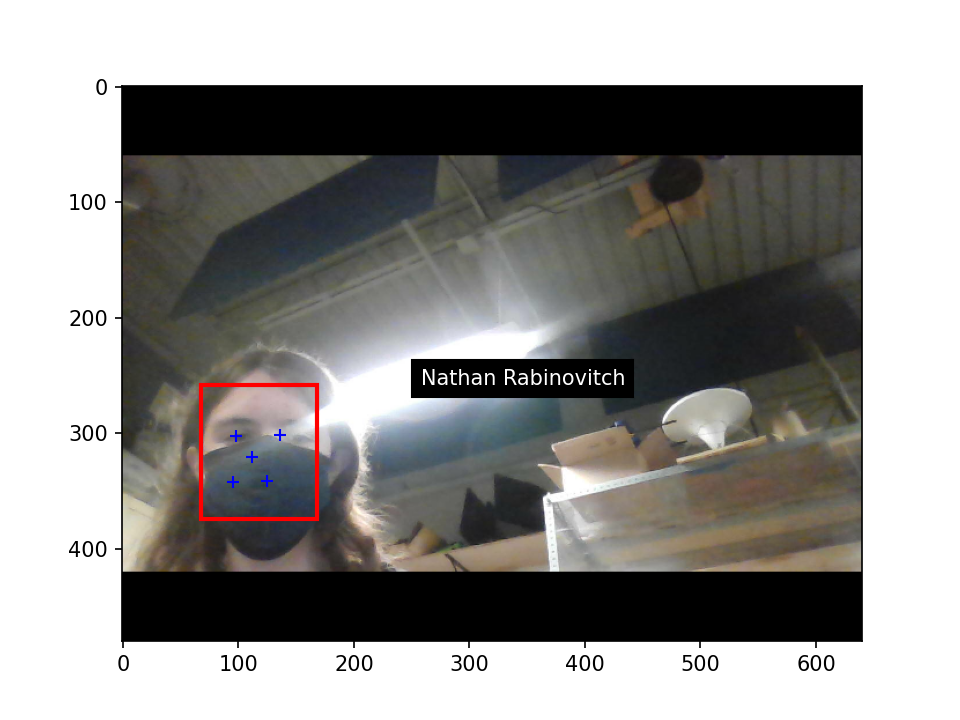

In [60]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots()
ax.imshow(pic)

for box, prob, landmark in zip(boxes, probabilities, landmarks):
    # draw the box on the screen
    ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), fill=None, lw=2, color="red"))

    # Get the landmarks/parts for the face in box d.
    # Draw the face landmarks on the screen.
    ax.text(box[1], box[1], name.split()[0].capitalize() + " " + name.split()[1].capitalize(), color="white", backgroundcolor="black")
    for i in range(len(landmark)):
        ax.plot(landmark[i, 0], landmark[i, 1], "+", color="blue")
        #ax.text(300,300,name, set)